In [131]:
import warnings
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from IPython import display
from sklearn.datasets import load_digits
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score # и другие метрики
from sklearn.cluster import KMeans, AgglomerativeClustering # а также другие алгоритмы
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree

In [2]:
DATA_PATH = "data"
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Реализация Kmeans

5 баллов

В данном задании вам предстоит дописать код класса `MyKMeans`. Мы на простом примере увидим, как подбираются центры кластеров и научимся их визуализировать.

Сгенерируем простой набор данных, 400 объектов и 2 признака (чтобы все быстро работало и можно было легко нарисовать):

In [3]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])

Напишем функцию `visualize_clusters`, которая по данным и меткам кластеров будет рисовать их и разукрашивать:

In [4]:
def visualize_clusters(X, labels):
    """
    Функция для визуализации кластеров
        :param X: таблица объекты х признаки
        :param labels: np.array[n_samples] - номера кластеров
    """
    
    unique_labels = np.sort(np.unique(labels))
    sns.scatterplot(X[:, 0], X[:, 1], hue=labels, 
                    palette="colorblind", legend=False,
                    hue_order=unique_labels)
    plt.xlabel("$X_1$", fontsize=18)
    plt.ylabel("$X_2$", fontsize=18)
    
    for label in labels:
        center = X[(labels == label)].mean(axis=0)
        plt.scatter(center[0], center[1], s=80, c="#201F12", marker=(5, 2))

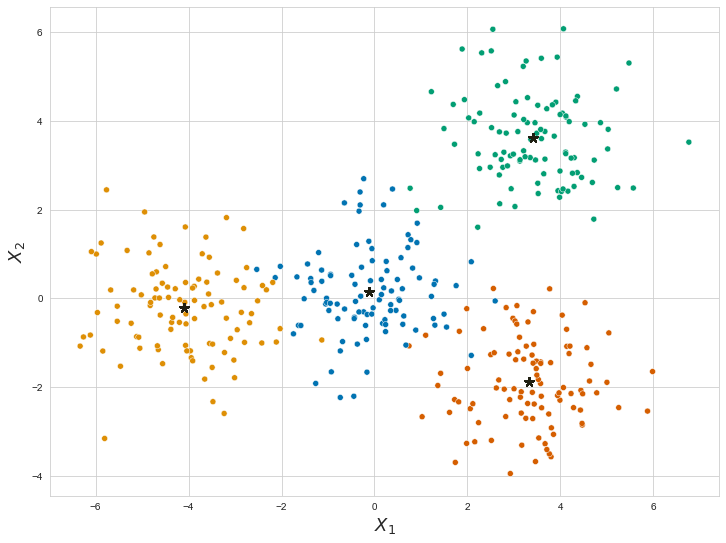

In [5]:
visualize_clusters(X, true_labels)

Напишем свой класс `MyKMeans`, который будет реализовывать алгоритм кластеризации K-средних. Напомним сам алгоритм:

1. Выбераем число кластеров (K)
2. Случайно инициализируем K точек (или выбираем из данных), это будут начальные центры наших кластеров
3. Далее для каждого объекта считаем расстояние до всех кластеров и присваиваем ему метку ближайщего
4. Далее для каждого кластера считаем "центр масс" (среднее значение для каждого признака по всем объектам кластера)
5. Этот "центр масс" становится новым центром кластера
6. Повторяем п.3, 4, 5 заданное число итераций или до сходимости

Во время предсказания алгоритм просто находит ближайщий центроид (центр кластера) для тестового объекта и возвращает его номер.

Реализуйте методы:
* `_calculate_distance(X, centroid)` - вычисляет Евклидово расстояние от всех объектов в `Х` до заданного центра кластера (`centroid`)
* `predict(X)` - для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент

In [42]:
class MyKMeans:
    def __init__(self, n_clusters, init="random", max_iter=300, visualize=False):
        """
        Конструктор класса MyKMeans
            :param n_clusters: число кластеров
            :param init: способ инициализации центров кластеров
                'random' - генерирует координаты случайно из нормального распределения
                'sample' - выбирает центроиды случайно из объектов выборки
            :param max_iter: заданное число итераций 
                (мы не будем реализовывать другой критерий остановки)
            :param visualize: рисовать ли кластеры и их центроиды в процессе работы
                код будет работать сильно дольше, но красиво...
        """
        
        assert init in ["random", "sample"], f"Неизвестный метод инициализации {init}"
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.visualize = visualize
       
    
    def fit(self, X):
        """
        Подбирает оптимальные центры кластеров
            :param X: наши данные (n_samples, n_features)
        :return self: все как в sklearn
        """
        
        n_samples, n_features = X.shape
        
        # Инициализация центров кластеров
        if self.init == "random":
            centroids = np.random.randn(self.n_clusters, n_features)
        elif self.init == "sample":
            centroids_idx = np.random.choice(np.arange(n_samples), 
                                             size=self.n_clusters, 
                                             replace=False)
            centroids = X[centroids_idx]
        
        # Итеративно двигаем центры
        for _ in range(self.max_iter):
            # Посчитаем расстояния для всех объектов до каждого центроида
            dists = []
            for centroid in centroids:
                dists.append(self._calculate_distance(X, centroid))
            dists = np.concatenate(dists, axis=1)
            # Для каждого объекта найдем, к какому центроиду он ближе
            cluster_labels = np.argmin(dists, axis=1)
            
            # Пересчитаем центр масс для каждого кластера
            centroids = []
            for label in np.sort(np.unique(cluster_labels)):
                center = X[(cluster_labels == label)].mean(axis=0)
                centroids.append(center)
            
            # Отрисуем точки, покрасим по меткам кластера, а также изобразим центроиды
            if self.visualize:
                visualize_clusters(X, cluster_labels)
                display.clear_output(wait=True)
                display.display(plt.gcf())
                plt.close()
                
        self.centroids = np.array(centroids)
        
        return self
    
    
    def predict(self, X):
        """
        Для каждого X возвращает номер кластера, к которому он относится
            :param X: наши данные (n_samples, n_features)
        :return cluster_labels: метки кластеров
        """
        
        """
        YOUR CODE IS HERE
        """
        inmed_list = []
        index_list = []
        for_index_list = []
        for i in self.centroids:
            inmed_list.append(self._calculate_distance(X, i))
        inmed_list = np.concatenate(inmed_list, axis=1)
        
        cluster_labels = np.argmin(inmed_list, axis=1)
            
        return cluster_labels
        
        
    def _calculate_distance(self, X, centroid):
        """
        Вычисляет Евклидово расстояние от всех объектов в Х до заданного центра кластера (centroid)
            :param X: наши данные (n_samples, n_features)
            :param centroid: координаты центра кластера
        :return dist: расстояния от всех X до центра кластера
        """
        
        """
        YOUR CODE IS HERE
        """
        dist = np.asarray([np.sqrt(np.sum((X - centroid) ** 2, axis=1))])
        dist = dist.transpose()
        
        return dist
    
    
    def __repr__(self):
        return f"Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*"

Обучите `MyKMeans` на наших игручешных данных, добейтесь сходимости. Не забудьте поставить `visualize=True`, чтобы посмотреть на красивые картинки. Также попробуйте различные способы инициализации центроидов и скажите, какой лучше подошел в этой ситуации.

300 c параметром  visualize=True работает неприлично долго, да и 20 циклов, по результатам эксперимента, хватает за глаза, так что 300 ставить не буду)

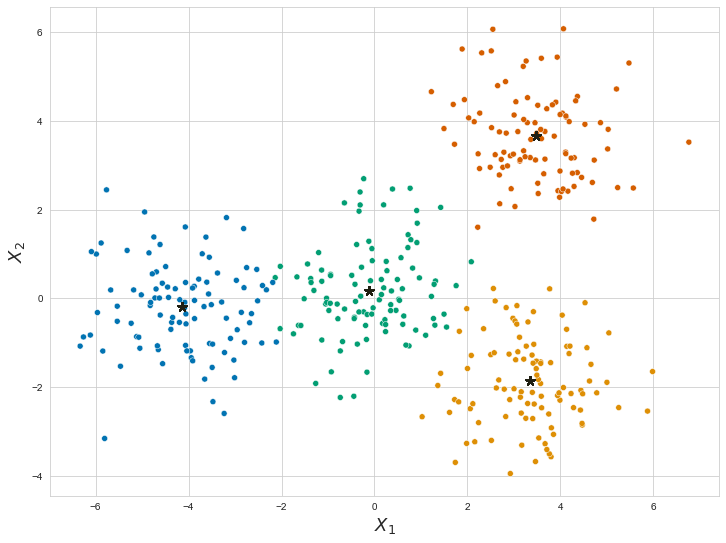

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [41]:
custom_kmeans = MyKMeans(n_clusters = 4, max_iter=20, visualize=True)
custom_kmeans.fit(X)

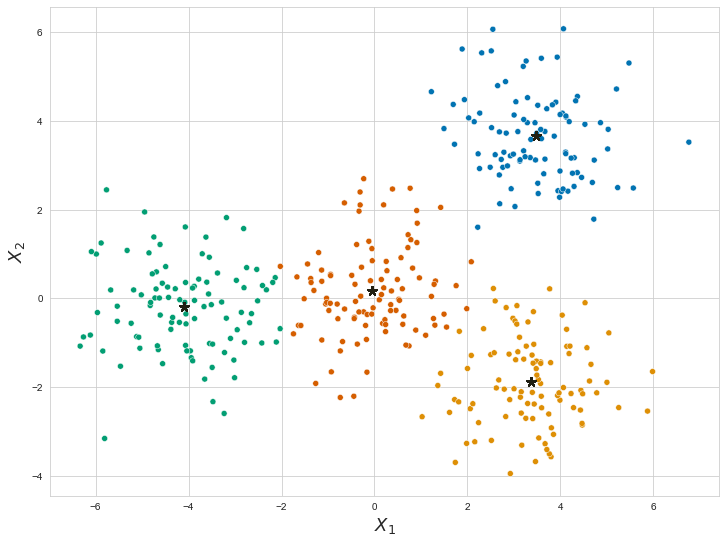

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [44]:
custom_kmeans = MyKMeans(n_clusters = 4, init="sample", max_iter=10, visualize=True)
custom_kmeans.fit(X)

ну с init="sample" всё ожидаемо работает быстрее)

так, а если запустить с двумя кластерами вместо четырёх, то центры должны уползти в середины пар ближайших кластеров, правильно?

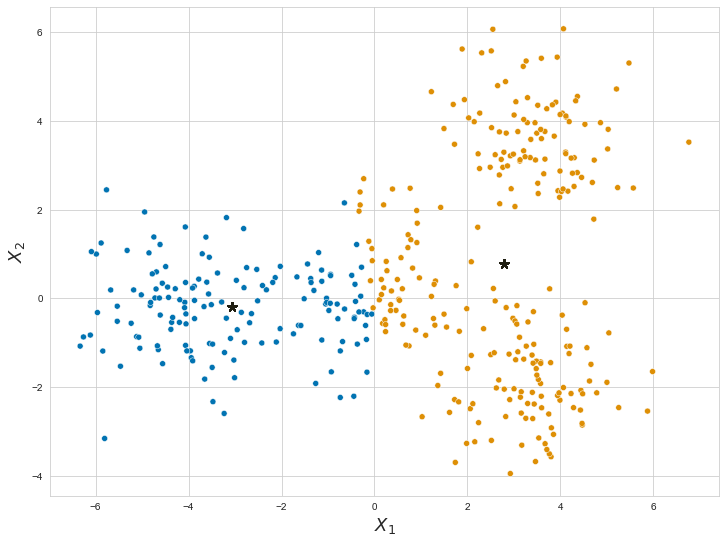

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [46]:
custom_kmeans = MyKMeans(n_clusters = 2, max_iter=10, visualize=True)
custom_kmeans.fit(X)

Не совсем) но забавно. А теперь 8 кластеров

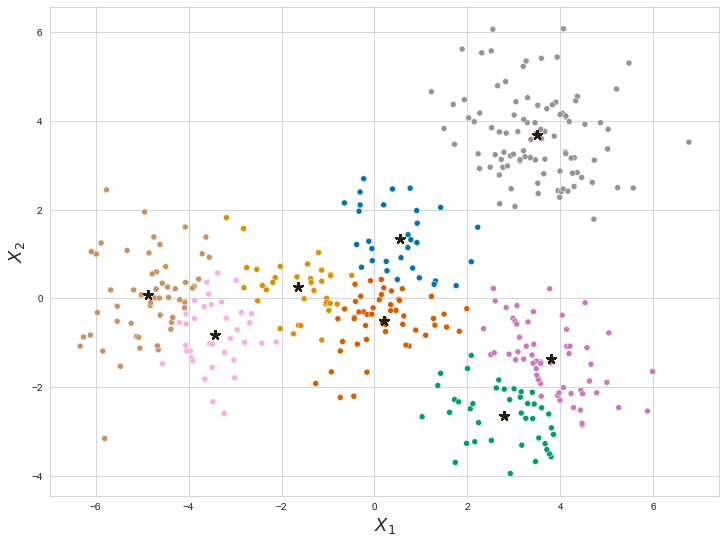

Привет, я твой KMeans (/¯◡ ‿ ◡)/¯☆*

In [47]:
custom_kmeans = MyKMeans(n_clusters = 8, max_iter=10, visualize=True)
custom_kmeans.fit(X)

In [ ]:
Тут, судя по всему, всё сильно зависит от стартовых параметорв)

### Задание 2. Подбираем лучшую иерархическую кластеризацию

5 баллов

На лекции были рассмотрены различные расстояния, которые могут служить метриками различия между объектами. Также мы разобрали несколько алгоритмов кластеризации, в том числе и иерархическую. Часто может быть непонятно, какой алгоритм и какую метрику расстояния нужно взять. Давайте упростим себе жизнь и напишем функцию `algorithm_selection`, которая будет на основании переданных ей:

* метрик расстояния (можно брать все, что было на лекциях, минимум 4)
* параметра `linkage` ('average', 'single', 'complete')
* и метрик качества кластеризации ('Homogeneity', 'Completeness', 'V-measure', 'Silhouette')

будет выводить итоговую таблицу, в которую войдут столбцы:
* 3 (метрика расстояния)
* linkage (алгоритм иерархической кластеризации)
* homogenity
* completeness
* v_measure
* silhouette

В результате по этой таблице, нужно сделать вывод о том, какой алгоритм кластеризации и с какими гиперпараметрами лучше всего сработал.

Загрузим наши данные:

In [48]:
data = load_digits()
X, y = data.data, data.target

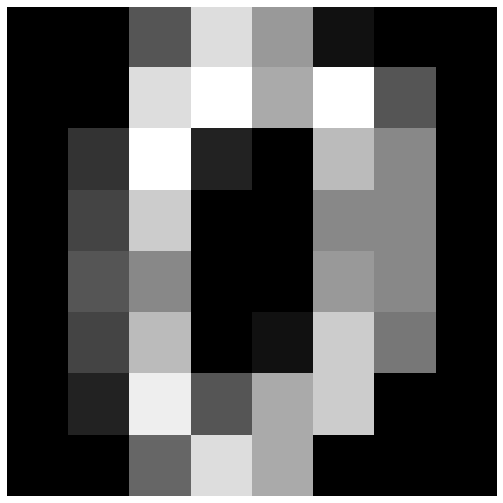

In [49]:
plt.imshow(X[0].reshape(8, 8).astype(int), cmap="gray")
plt.axis("off");

Работать будем с изображениями рукописных цифр. Тут все похоже на данные для 1 домашнего задания, каждая картинка представлена вектором из 64 элементов (числа от 0 до 255). Чтобы ее нарисовать мы должны сделать `reshape` в картинку 8 на 8 пикселей. Вам нужно будет выбрать наилучший способ кластеризации при помощи функции `algorithm_selection`, которую вы реализуете. Для некоторых метрик кластеризации требуются метки **классов** объектов (они хранятся в переменной `y`). Укажите для каждого алгоритма число кластеров равное количеству классов в `y`.

##### YOUR TURN TO CODE

In [68]:
def algorithm_selection(X, distances=['euclidean', 'l1', 'l2', 'manhattan', 'cosine'], algorithms=['complete', 'average', 'single'], metrics=['homogenity', 'completeness', 'v_measure', 'silhouette']):
    """
    Для заданных алгоримов кластеризации и гиперпараметров 
    считает различные метрики кластеризации
        :param X: наши данные (n_samples, n_features)
        :param distances: список возможных метрик расстояния
        :param algorithm: параметр linkage ('average', 'single', 'complete')
        :param metrics: список возможных метрик качества кластеризации
    :return compare_dataframe: таблица с метриками кластеризации
    """

    """
    YOUR CODE IS HERE
    """
    cluster_number = len(np.unique(y))
    metric_formulas = {'homogenity': homogeneity_score, 'completeness': completeness_score, 'v_measure': v_measure_score, 'silhouette': silhouette_score}
    res_table = []
    interm_table = []
    for algorithm in algorithms:
        for distance in distances:
            interm_table.append(distance)
            interm_table.append(algorithm)
            test_alg = AgglomerativeClustering(n_clusters=cluster_number, affinity=distance, linkage=algorithm)
            test_alg.fit(X)
            for metric in metrics:
                if metric != "silhouette":
                    interm_table.append(metric_formulas[metric](y, test_alg.labels_))
                else:
                    interm_table.append(metric_formulas[metric](X, test_alg.labels_, metric=distance))
            res_table.append(interm_table)
            interm_table = []
            
    columns = ['distance'] + ['algorithm'] + metrics
    compare_dataframe = pd.DataFrame(res_table, columns=columns)
    
    return compare_dataframe

In [69]:
algorithm_selection(X)

distance algorithm  homogenity  completeness  v_measure  silhouette
0   euclidean  complete    0.590549      0.637772   0.613253    0.119271
1          l1  complete    0.646372      0.686109   0.665648    0.160617
2          l2  complete    0.590549      0.637772   0.613253    0.119271
3   manhattan  complete    0.646372      0.686109   0.665648    0.160617
4      cosine  complete    0.528727      0.577415   0.551999    0.144179
5   euclidean   average    0.655393      0.782342   0.713263    0.146625
6          l1   average    0.566751      0.778942   0.656117    0.105238
7          l2   average    0.655393      0.782342   0.713263    0.146625
8   manhattan   average    0.566751      0.778942   0.656117    0.105238
9      cosine   average    0.648268      0.808762   0.719676    0.218229
10  euclidean    single    0.005056      0.273755   0.009929   -0.133621
11         l1    single    0.005102      0.276237   0.010019   -0.203816
12         l2    single    0.005056      0.273755   0.009929   -0.133621
13  manhattan    single    0.005102      0.276237   0.010019   -0.203816
14     cosine    single    0.005050      0.273389   0.009916   -0.281789

In [ ]:
Выглядит так, как будто в среднем по совокупности параметров лучший - "cosine average"

### Задание 3. Аннотация клеточных типов

суммарно 10 баллов

В этом задании вам предстоит применять полученные знания о кластеризации для аннотации данных, полученных при помощи проточной цитометрии. Каждая строка в данных это одна клетка, столбцы **FSC-A**, **SSC-A** косвенным образом свидетельствуют о размере клеток, остальные показывают интенсивность флуоресценции различных поверхностных маркеров. Ваша задача определить для каждой клетки, к какому типу она относится.

#### 3.1. EDA

1.5 балла

Проведите EDA:

1. Посмотрите на данные (можно попробовать метод `describe`)
2. Сколько у нас клеток / признаков
3. Постройте распределения каждого признака (есть ли очевинные выбросы?)

In [71]:
fc_data = pd.read_csv(join(DATA_PATH, "D:/downloads/flow_c_data.csv"), index_col=0)

##### YOUR TURN TO CODE:

In [73]:
fc_data.describe()

FSC-A         SSC-A        HLA-DR           CD3          CD45  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean       0.962458      0.165415      1.791579      3.280391      5.169845   
std        0.500012      0.190773      2.027281      2.112079      0.518247   
min        0.144786      0.021657     -7.634172     -2.517639     -8.329666   
25%        0.798804      0.105550      0.275056      1.401943      4.922227   
50%        0.908574      0.130543      1.194313      4.373660      5.234119   
75%        1.052034      0.162536      3.696976      4.842212      5.481218   
max       42.954485     15.460997     12.946668     13.844391     13.710922   

               CD14          CD56          CD19         CD11c  
count  10000.000000  10000.000000  10000.000000  10000.000000  
mean       1.097182      0.412223      1.219683      0.569898  
std        1.375876      1.176967      2.285305      1.502445  
min       -8.833883    -12.358701     -9.640775    -11.085437  
25%        0.389746     -0.195978     -0.146948     -0.498781  
50%        0.672853      0.053267      0.244121      0.272297  
75%        1.065076      0.378576      0.908374      1.220576  
max        6.294236      6.461899      7.208721      6.840864

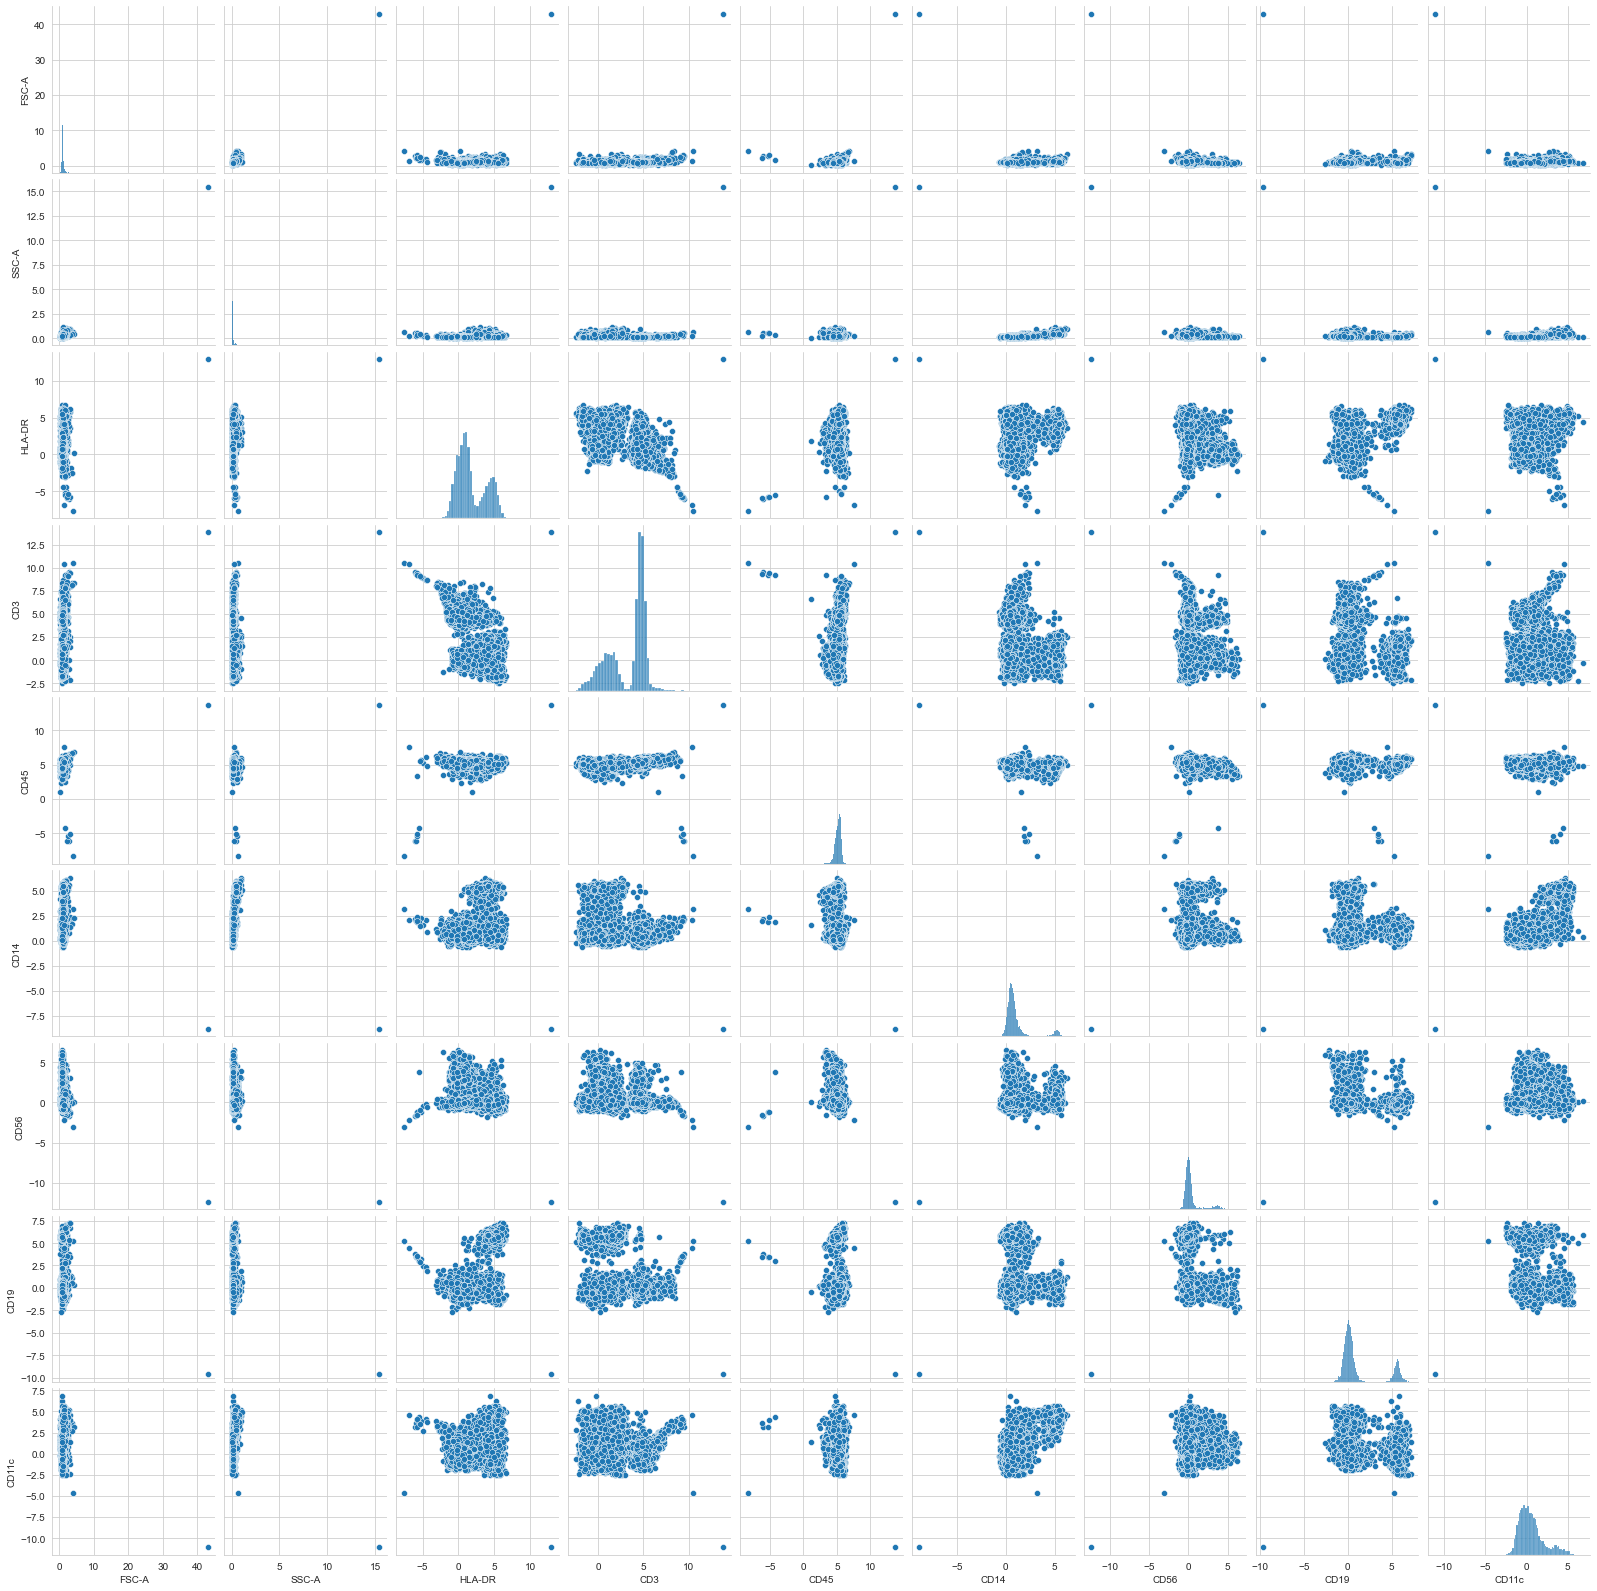

In [74]:
sns.pairplot(fc_data)

Похоже, в образце есть одна здоровенная клетка (мусор), которая сильно искажает выборку. попробуем её убрать

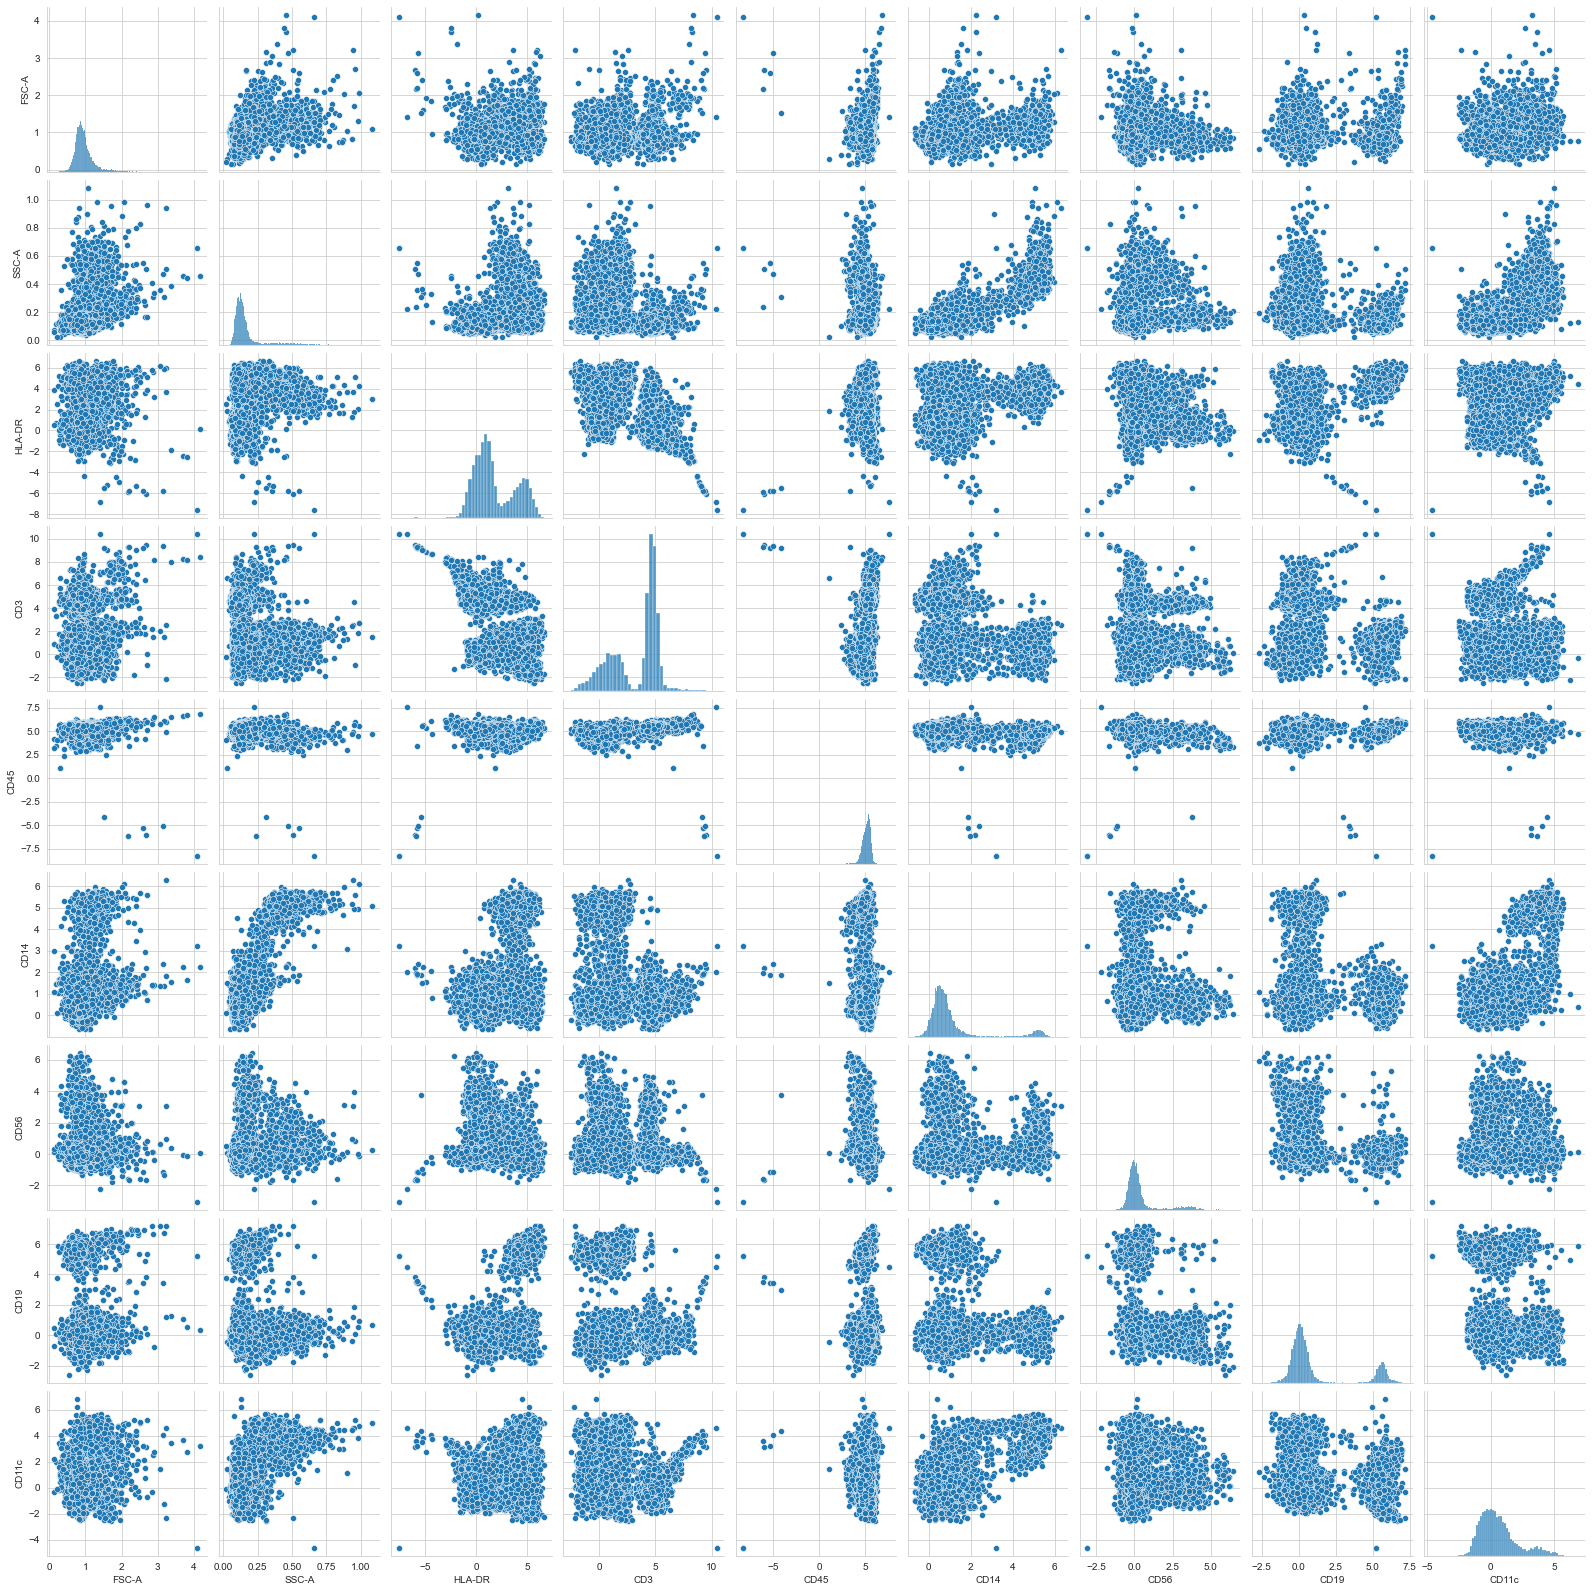

In [77]:
fc_data_notrash = fc_data[fc_data['FSC-A'] != 42.954485]
sns.pairplot(fc_data_notrash)

Какие-то выбросы всё-равно есть, но выгляди так, как будто их мало и они не должны значимо влиять на результат.

#### 3.2. Кластеризация

4.5 балла

При ручной аннотации клеточных типов обычно поступают следующим образом:

1. При помощи методов понижения размерности рисуют наши наблюдения, чтобы примерно оценить число клеточных типов
2. Проводят кластеризацию наблюдений (для некоторых методов нужно заранее задать число кластеров, поэтому нам как раз помогает п.1)
3. Далее мы считаем, что клетки, которые алгоритм отнес к одному кластеру являются одним клеточным типом (если кластеров больше, чем типов клеток, то возможно, что 2 разных кластера являются одним типом)
4. После чего по интенсивности экспрессии поверхностных маркеров мы присваиваем кластеру клеточный тип

Давайте для начала напишем удобную функцию для визуализации наших многомерных данных в пространстве размерностью 2, делать мы это будем при помощи алгоритма t-SNE.

Поиграться с красивой визуализацией можно [тут](https://distill.pub/2016/misread-tsne/).

In [78]:
def plot_tsne(data, n_iter=1000, 
              perplexity=40, color=None):
    """
    Функция для отрисовки результатов работы t-SNE
        :param data: таблица объекты х признаки
        :param n_iter: число итераций градиентного спуска,
            может быть полезно увеличить, чтобы получить результаты получше
        :param perplexity: 
        :param color: np.array[n_samples] с переменной,
            которой мы хотим покрасить наши наблюдения
        :return tsne_emb: np.array[n_samples, 2] - результаты работы t-SNE
    """
    
    # Сначала сделаем PCA, так как это хорошее начальное приближение для t-SNE
    # позволит алгоритму быстрее сойтись
    pca = PCA().fit(data)
    pca_embedding = pca.transform(data)
    
    # Запустим t-SNE, он выдаст нам для каждого объекта по 2 числа, 
    # которые мы сможем нарисовать
    tnse = TSNE(n_components=2, init=pca_embedding[:, :2], n_jobs=-1,
                n_iter=n_iter, perplexity=perplexity)
    tsne_embedding = tnse.fit_transform(pca_embedding)
    
    sns.scatterplot(x=tsne_embedding[:, 0],
                    y=tsne_embedding[:, 1],
                    hue=color, palette="colorblind")
    plt.xlabel("$TSNE_1$", fontsize=18)
    plt.ylabel("$TSNE_2$", fontsize=18)
    
    # Вернем также результаты t-SNE, так как, если потом захотим перестроить картинку,
    # в таком случае нам не придется ждать заново, просто нарисуем новую с готовыми данными
    
    return tsne_embedding

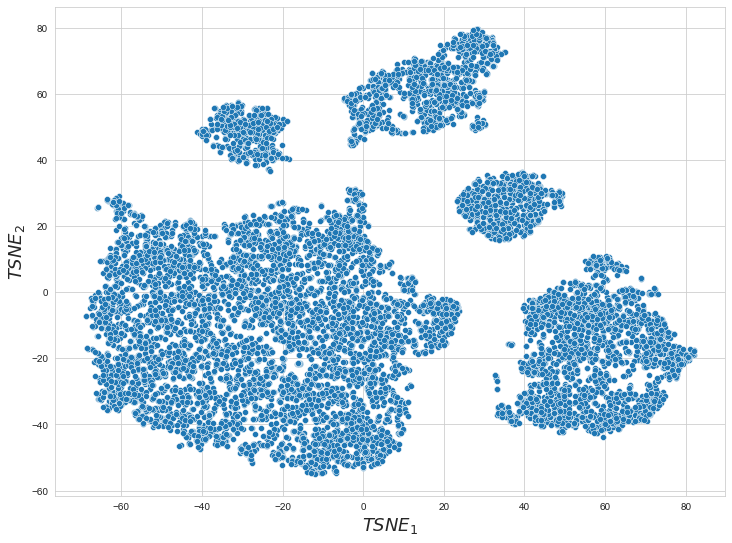

In [79]:
tsne_res = plot_tsne(fc_data_notrash)

In [ ]:
Выглядит так, как будто кластеров от 5 до 9.

Кластеризуйте ваши данные:

1. Попробуйте методы кластеризации из тех, что мы прошли
2. Выберите лучший на основании метрики `silhouette_score` (попробуйте также подобрать гиперпараметры)
3. Присвойте каждому наблюдению метку класса и нарисуйте график t-SNE, покрасив точки метками кластера

К сожалению, наша функция algorithm_selection не принимает на вход количество кластеров, а считает его по y, поэтому придётся сделать небольшой костыль)

In [83]:
for i in range(4, 10):
    y = [j for j in range(i)]
    print(str(i))
    print(algorithm_selection(fc_data_notrash, metrics=['silhouette']))

     distance algorithm  silhouette
0   euclidean  complete    0.470696
1          l1  complete    0.453568
2          l2  complete    0.470696
3   manhattan  complete    0.453568
4      cosine  complete    0.739807
5   euclidean   average    0.449268
6          l1   average    0.442601
7          l2   average    0.449268
8   manhattan   average    0.442601
9      cosine   average    0.776614
10  euclidean    single    0.635343
11         l1    single    0.671818
12         l2    single    0.635343
13  manhattan    single    0.671818
14     cosine    single    0.293495
     distance algorithm  silhouette
0   euclidean  complete    0.506287
1          l1  complete    0.444794
2          l2  complete    0.506287
3   manhattan  complete    0.444794
4      cosine  complete    0.838267
5   euclidean   average    0.511313
6          l1   average    0.622765
7          l2   average    0.511313
8   manhattan   average    0.622765
9      cosine   average    0.848101
10  euclidean    single    0

Так, самый высокий silhouette у пяти кластеров с параметрами  "cosine   average" - 0.848101. На нём и остановимся)

In [101]:
cell_alg = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='average')
cell_alg.fit(fc_data_notrash)
cell_alg.labels_

array([4, 3, 0, ..., 2, 4, 4], dtype=int64)

Text(0, 0.5, '$TSNE_2$')

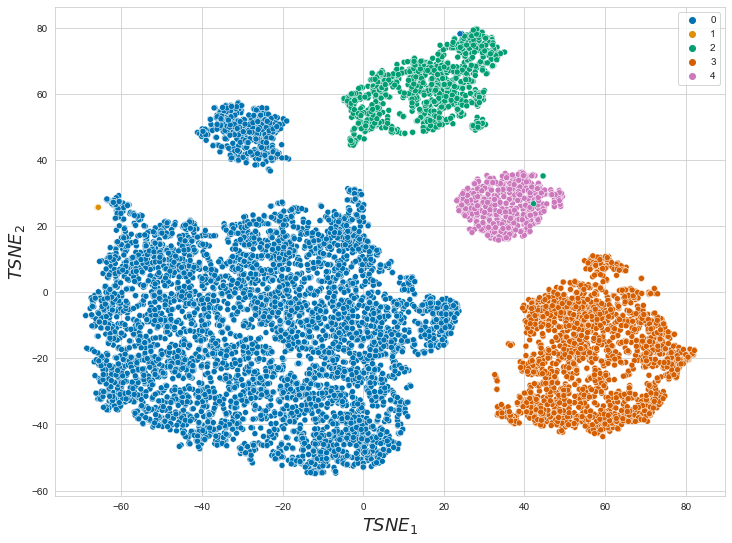

In [102]:
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=cell_alg.labels_, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

Жёлтый кластер из одной точки это кек, конечно) Переделаем с четырьмя кластерами с лучшим скором:

Text(0, 0.5, '$TSNE_2$')

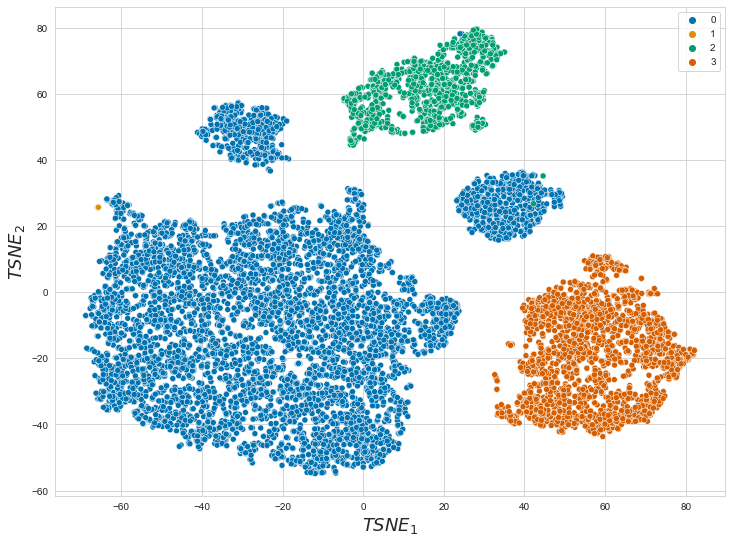

In [94]:
cell_alg = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average')
cell_alg.fit(fc_data_notrash)
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=cell_alg.labels_, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

Только хуже стало. Попробуем 6 и 7 кластеров.

Text(0, 0.5, '$TSNE_2$')

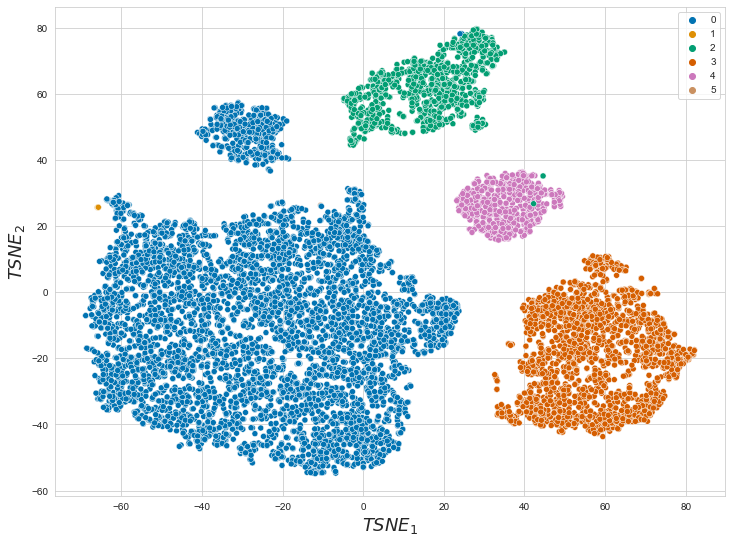

In [95]:
cell_alg = AgglomerativeClustering(n_clusters=6, affinity='cosine', linkage='average')
cell_alg.fit(fc_data_notrash)
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=cell_alg.labels_, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

Text(0, 0.5, '$TSNE_2$')

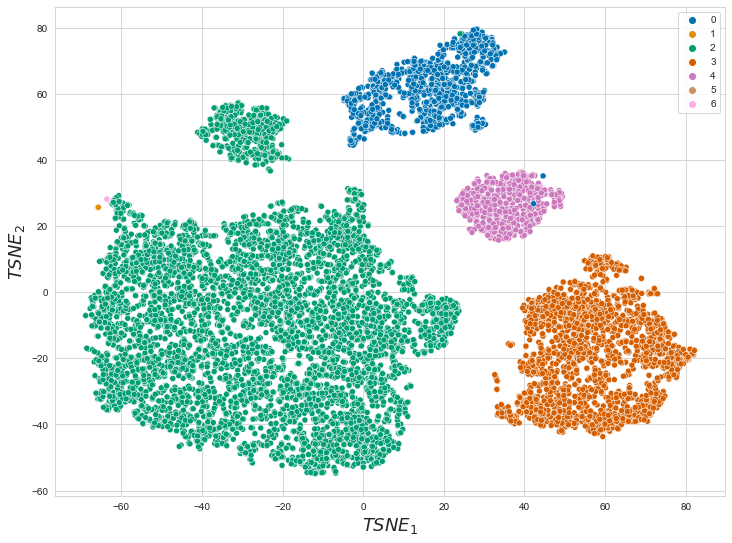

In [96]:
cell_alg = AgglomerativeClustering(n_clusters=7, affinity='cosine', linkage='average')
cell_alg.fit(fc_data_notrash)
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=cell_alg.labels_, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

Лучше не становится, поэтому я возьму пять кластеров как лучший вариант.

Text(0, 0.5, '$TSNE_2$')

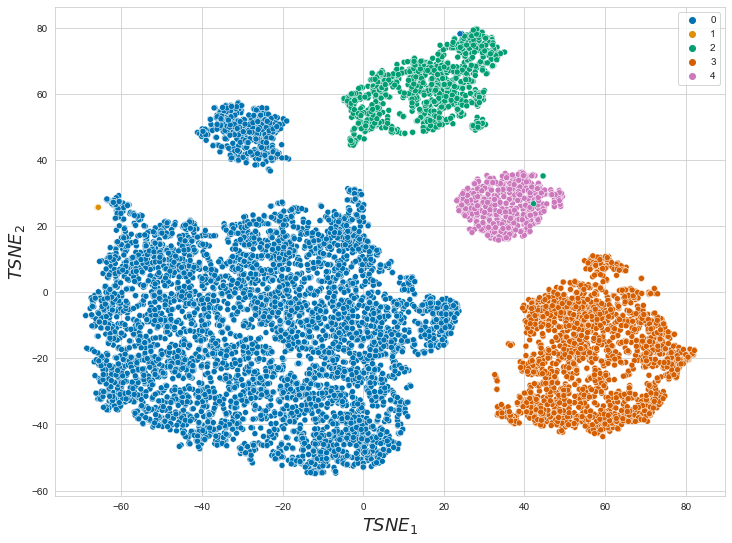

In [104]:
cell_alg = AgglomerativeClustering(n_clusters=5, affinity='cosine', linkage='average')
cell_alg.fit(fc_data_notrash)
cell_alg.labels_
sns.scatterplot(x=tsne_res[:, 0], y=tsne_res[:, 1], hue=cell_alg.labels_, palette="colorblind")
plt.xlabel("$TSNE_1$", fontsize=18)
plt.ylabel("$TSNE_2$", fontsize=18)

Удалось ли вам получить ситуацию, где отдельные группы точек покрашены в один цвет?

Скорее да, чем нет)

#### 3.3. Аннотация клеточных типов

4 балла

Теперь когда мы подобрали хороший алгоритм кластеризации, можно аннотировать наши клетки. Для этого мы нарисуем t-SNE и покрасим точки в зависимости от интенсивности экспрессии поверхностных маркеров. В датасете присутствуют следующие типы клеток:

* B_cells
* T_cells
* Monocytes
* Other cells

Вам нужно будет выяснить, какие клетки экспрессируют определенные маркеры и присвоить каждому кластеру один из типов клеток.

Добавил ещё один тип клеток, потому что он хорошо виден на графике и определяется по маркерам
* B_cells - CD19+ кластер 3;
* T_cells - CD3+ кластер 1;
* Monocytes - CD14+ кластер 2;
* NK_cells - CD56+ кластер 4;
* Other cells - всё остальное кластер 0, видимо) 

Для начала нарисуем все это безобразие:

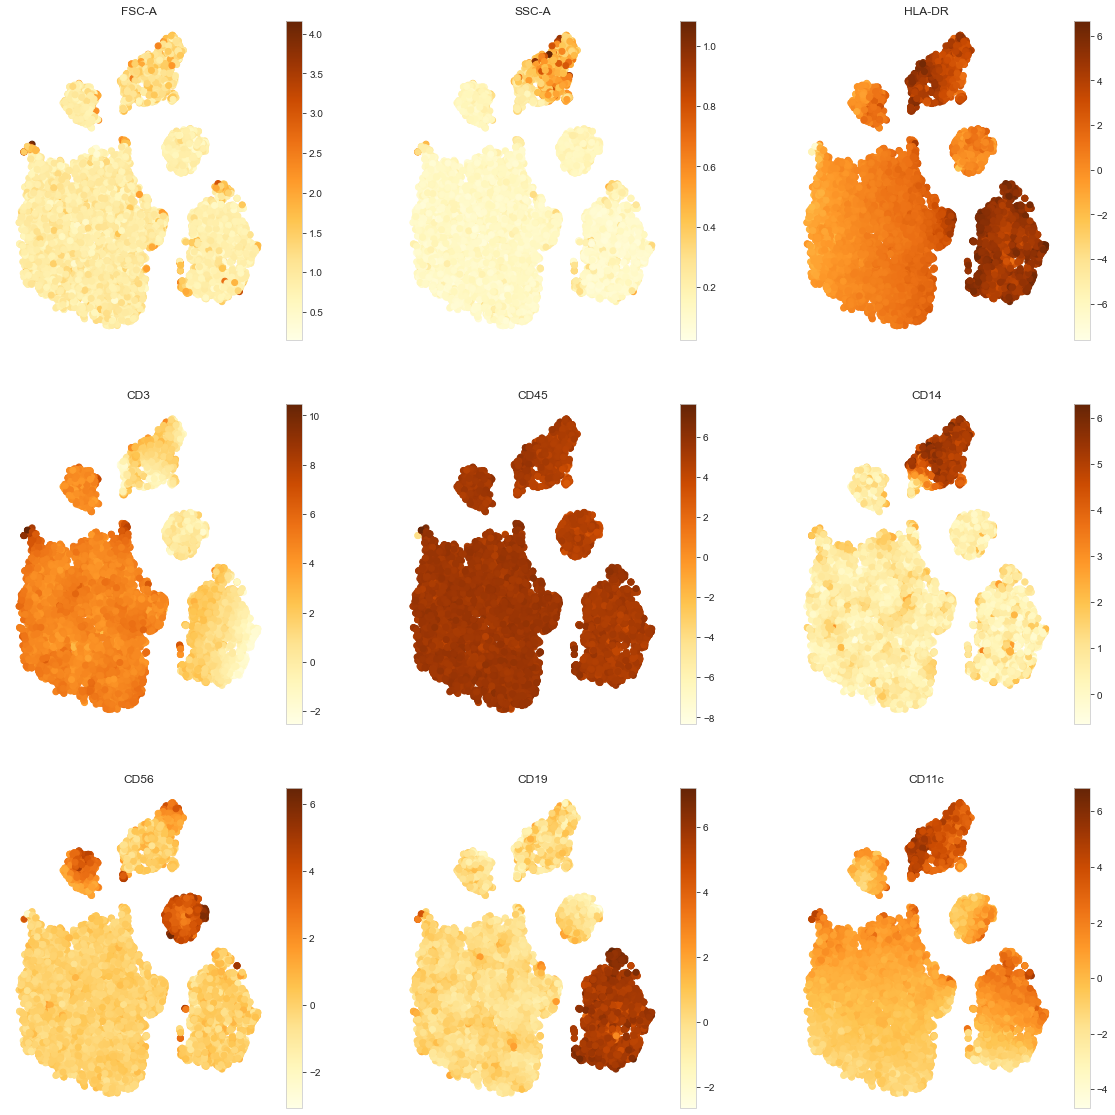

In [103]:
# Результаты t-SNE уже есть в переменной tsne_res
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for col, ax in zip(fc_data_notrash.columns, axes.ravel()):
    scatter = ax.scatter(tsne_res[:, 0], tsne_res[:, 1], 
                         c=fc_data_notrash[col], cmap="YlOrBr")
    fig.colorbar(scatter, ax=ax)
    ax.set_title(col)
    ax.grid(False)
    ax.axis("off")

Дальше дело за вами, нужно определить клеточный тип для каждого кластера и записать их как значения в словаре:

In [107]:
cell_type_cluster_map = {0: "Other_cells", 
                         1: "T_cells", 
                         2: "Monocytes", 
                         3: "B_cells", 
                         4: "NK_cells"}

In [109]:
labeled_fc_data = fc_data_notrash.assign(Population=cell_alg.labels_)
labeled_fc_data["Population"] = labeled_fc_data["Population"].map(cell_type_cluster_map)

Посчитайте, как распределены типы клеток:

In [111]:
labeled_fc_data.groupby(['Population']).size()

Population
B_cells        2035
Monocytes      1100
NK_cells        632
Other_cells    6226
T_cells           6
dtype: int64

Сохраните ваши результаты в csv файл, мы сравним их с правильными ответами по метрике `f1_score(average="macro")`, которая хорошо подходит, даже если классы не сбалансированы.

In [115]:
labeled_fc_data.to_csv('cell_type_results.csv', sep='\t')

#### 3.4. Автоматическая аннотация

**дополнительные** 5 баллов

Это задание является дополнительным. Вам нужно построить классификатор клеточных типов на основе размеченных вами данных. Пока что мы прошли не так много разных классификаторов, но уже есть из чего выбирать.

Оцените качество полученной модели при помощи `f1_score(average="macro")`. Попробуйте его улучшить, каким-то образом поработав с дисбалансом классов ([помощь](https://elitedatascience.com/imbalanced-classes)).

Тут, по идее, должно неплохо зайти дерево решений, потому что признаки у нас по сути по каждому маркеру есть два состояния - высокая экспрессия и низкая экспрессия. Ну и нормировать мне лень, а в дереве это не надо.

Сразу сбросим непоказательные признаки:FSC-A, SSC-A (он как бы показательный, только у нас на эту группу есть лучше), HLA-DR, CD45.

In [121]:
X = labeled_fc_data.drop(['FSC-A', 'SSC-A', 'HLA-DR', 'CD45', 'Population'], axis=1)
y = cell_alg.labels_
X.head()

CD3      CD14      CD56      CD19     CD11c
0  0.512853  1.019255  4.007273 -1.406912  0.384406
1  0.822042  0.159388 -0.216407  6.034845  0.577039
2  4.006353  0.519223  0.783077 -0.318668 -0.493832
3  3.332310  1.481229  0.264846  0.694883  3.416960
4  0.885501  0.217117  0.086279  5.563345  0.471591

In [122]:
clf = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [123]:
clf.score(X_train, y_train)

1.0

In [124]:
clf.score(X_test, y_test)

0.9966666666666667

Ну собственно, так и вышло) Думаю, если посмотреть на дерево, там всё будет очень очевидно

In [128]:
tree.plot_tree(clf)
plt.show()

In [132]:
f1_score(y_test, clf.predict(X_test), average='macro')

0.7937198470904191

Ладно, и так сойдёт, у меня ещё kaggle там не улучшенный))

### Задание 4. Любимое место

дополнительно 0.5 балла

Расскажите о вашем любимом месте, куда бы вы хотели съездить этой весной, если вы уже там бывали, то прикрепите фотографию)

Мы пару лет назад были в Караколе, и вот сам город - ничем не примечательный маленький туристический хаб, но есть там одна кофейня, которая как будто из другого мира) Европейский ассортимент, настолки, атмосфера) Очень мы там хорошо посидели после похода, хотелось бы как-нибудь вернуться.

### Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**